# Import Library

Menginstall library scikit-surprise dan downgrade numpy ke versi 1.23.5 agar kompatibel dengan scikit-surprise

setelah install restart session lalu run ulang lagi dan cancel jika sudah restart session

In [33]:
# Uninstall numpy versi terbaru
!pip uninstall -y numpy

# # Lalu install lagi numpy yang kompatibel dengan scikit-surprise
!pip install numpy==1.23.5

# Menggunakan versi numpy yang kemungkinan kompatibel dengan scikit-surprise
!pip install scikit-surprise


Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.7 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
db-dtypes 1.4.3 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but yo

Tahap pertama adalah mengimport semua library yang akan di pakai

In [34]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

print("Library berhasil di Import")

Library berhasil di Import


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1. DATA LOADING**

Dataset Book Crossing dimuat kedalam DataFrame pandas. Dataset ini terdiri dari beberapa file CSV diantaranya:
- `BX-Book-Ratings.csv`: Berisi informasi mengenai rating buku oleh user
- `BX-Books.csv`: Berisi informasi tentang detail buku
- `BX-Users.csv`: Berisi informasi tentang pengguna


In [36]:
# Load dataset
print('--- Load Dataset ---')
ratings = pd.read_csv('/content/drive/MyDrive/Dataset/Dataset_buku/BX-Book-Ratings.csv', encoding='latin1', sep=';',on_bad_lines='skip')
books = pd.read_csv('/content/drive/MyDrive/Dataset/Dataset_buku/BX-Books.csv', encoding='latin1', sep=';',on_bad_lines='skip')
users = pd.read_csv('/content/drive/MyDrive/Dataset/Dataset_buku/BX-Users.csv', encoding='latin1', sep=';',on_bad_lines='skip')
print('\n--- Dataset Berhasil di Load ---')

--- Load Dataset ---


<ipython-input-36-6d0fdeae7e52>:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('/content/drive/MyDrive/Dataset/Dataset_buku/BX-Books.csv', encoding='latin1', sep=';',on_bad_lines='skip')



--- Dataset Berhasil di Load ---


Membaca dataset
- dataset memiliki encoding karakter yang tidak kompatibel dengan default `utf-8`. sehingga dataset dibaca dengan menambahkan `encoding='latin1'`
- mengganti delimiter dengan `';'`
- dataset tidak sepenuhnya terload karena ada beberapa data yang rusak, jadi disini memakai `on_bad_lines='skip'` agar data yang tidak bisa di load di lewati

# **2. DATA UNDERSTANDING**

Pada tahap ini, dilakukan Exploratory Data Analysis (EDA) untuk memahami struktur data dan memperoleh insight dari data

Langkah langkah EDA antara lain:
- menampilkan informasi data untuk memahami struktur data, jumlah data, tipe data, serta jumlah nilai non-null menggunakan `.info()`
- Menampilkan beberapa baris pertama dataset menggunakan `.head()`
- Menghitung statistik dasar seperti jumlah pengguna unik, jumlah buku unik, dan jumlah total rating.
- Membuat visualisasi distribusi rating, usia pengguna, tahun terbit buku dll.


## **2.1. Menampilkan Informasi Struktur Dataset**

Menggunakan fungsi `.info()` untuk memahami struktur data

In [37]:
# Menampilkan info dataset
print(' --- Rating Dataset --- ')
ratings.info()
print('\n --- Book Dataset --- ')
books.info()
print('\n --- User Dataset --- ')
users.info()

 --- Rating Dataset --- 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB

 --- Book Dataset --- 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-UR

Dari Informasi dataset diatas

1. Rating Dataset

  - Jumlah Data: Terdapat 1.149.780 entri rating, yang menunjukkan dataset rating yang cukup besar.
  - Kelengkapan Data:
    - `User-ID`: (1.149.780 non-null). Tipe datanya `int64`.
    - `ISBN`: (1.149.780 non-null). Tipe datanya `object` (string).
    - `Book-Rating`: (1.149.780 non-null). Tipe datanya `int64`.

  Dari data rating tidak terdapat nilai yang hilang dan tipe datanya sesuai

2. Book Dataset
  
  - Jumlah Data: Terdapat 271.360 entri buku.
  - Kelengkapan Data:
    - `ISBN`, `Book-Title`, `Image-URL-S`, `Image-URL-M`: Lengkap.
    - `Book-Author`: terdapat missing value dalam data (271.358 non-null dari 271.360).
    - `Publisher`: terdapat missing value (271.358 non-null dari 271.360). Perlu penanganan seperti `Book-Author`.
    - `Image-URL-L`: Sedikit data hilang (271.357 non-null dari 271.360). Kolom URL gambar mungkin tidak krusial untuk model rekomendasi, sehingga nantinya kolom ini tidak akan dipakai atau di hapus.

  - Tipe Data:
    - Semua kolom bertipe object (string).
    - **Perhatian Khusus**: `Year-Of-Publication` bertipe `object`. Ini sangat mungkin berarti ada nilai non-numerik di dalamnya (misalnya, teks atau format tahun yang salah). Kolom ini perlu dibersihkan dan dikonversi ke tipe numerik (`integer`) agar bisa digunakan untuk analisis atau sebagai fitur.    

3. User Dataset
  
  - Jumlah Data: Terdapat 278.858 entri pengguna.
  - Kelengkapan Data:
    - `User-ID`: Lengkap (278.858 non-null). Tipe datanya `int64`.
    - `Location`: Lengkap (278.858 non-null). Tipe datanya `object`.
    - `Age`: Banyak data hilang (hanya 168.096 non-null dari 278.858). Ini berarti sekitar 39.7% data usia hilang. Perlu  penanganan yang cermat.
  - Tipe Data:
    - `Age` bertipe `float64`. seharusnya `int`.

In [38]:
# Menampilkan 5 baris awal data rating
print(' --- Rating Dataset ---')
ratings.head(5)


 --- Rating Dataset ---


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [39]:
# Menampilkan 5 baris awal data buku
print(' --- Book Dataset ---')
books.head(5)

 --- Book Dataset ---


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [40]:
# Menampilkan 5 baris awal data user
print(' --- User Dataset ---')
users.head(5)

 --- User Dataset ---


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


## **2.2. Visualisasi Distribusi Usia Pengguna (Sebelum pembersihan)**

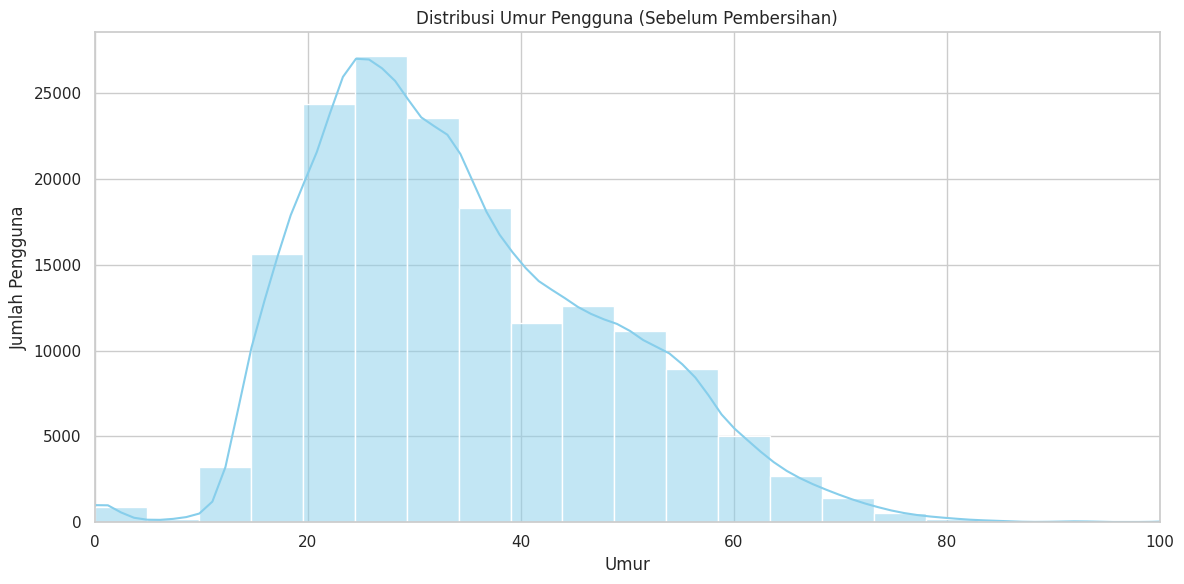

In [41]:
# Set style for better visuals
sns.set(style="whitegrid")

# Plot distribusi umur sebelum pembersihan
plt.figure(figsize=(12, 6))
sns.histplot(users['Age'], bins=50, kde=True, color='skyblue')
plt.title("Distribusi Umur Pengguna (Sebelum Pembersihan)")
plt.xlabel("Umur")
plt.ylabel("Jumlah Pengguna")
plt.xlim(0, 100)  # Fokus pada rentang yang wajar
plt.tight_layout()
plt.show()

- Mayoritas pengguna berusia antara 15 hingga 50 tahun.

- Ada outlier di bawah 5 tahun dan di atas 100 tahun (termasuk 0 dan 244), yang tampaknya tidak valid.

Selanjutnya:
data usia yang tidak valid akan di bersihkan dengan cara:

- Menjadikan NaN jika usia < 5 atau > 100

- Lalu, kita bisa imputasi NaN dengan median atau membiarkannya tergantung kebutuhan.

## **2.3. Distribusi Tahun terbit buku**

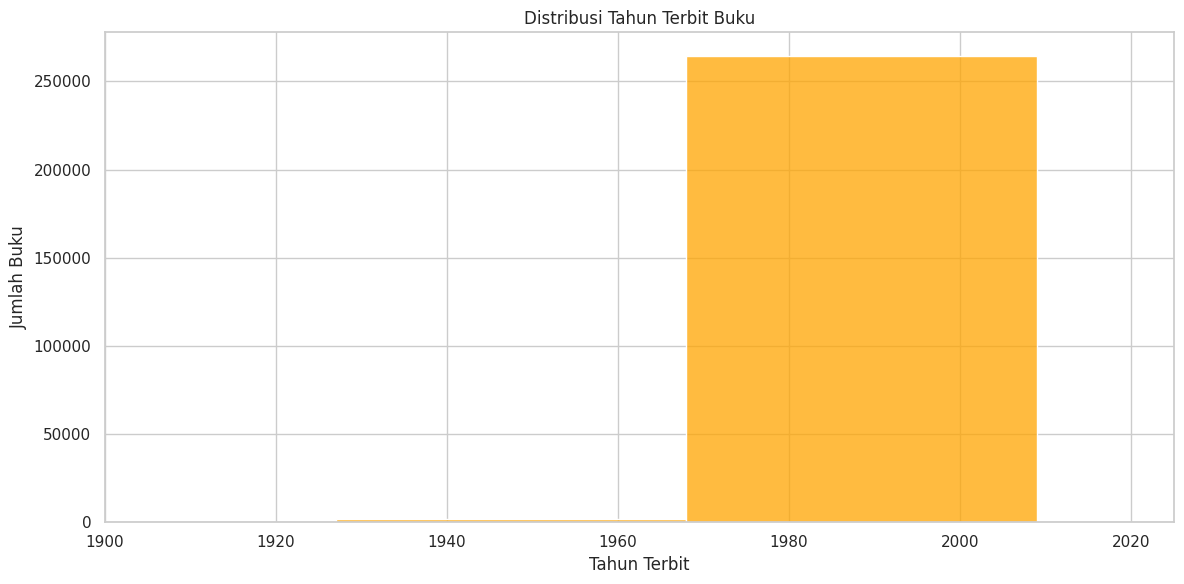

In [42]:
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')

plt.figure(figsize=(12, 6))
sns.histplot(books['Year-Of-Publication'].dropna(), bins=50, color='orange')
plt.title("Distribusi Tahun Terbit Buku")
plt.xlabel("Tahun Terbit")
plt.ylabel("Jumlah Buku")
plt.xlim(1900, 2025)
plt.tight_layout()
plt.show()

- Sebagian besar buku terbit antara 1950–2005.

- Terdapat nilai tidak valid seperti:

  - Tahun 0

  - Tahun lebih dari 2025

- Hal ini menunjukkan adanya noise yang perlu dibersihkan sebelum analisis atau sistem rekomendasi dilakukan.

## **2.4. Buku terbanyak per penerbit**

<ipython-input-43-310fd7a7713c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_publishers.values, y=top_publishers.index, palette='magma')


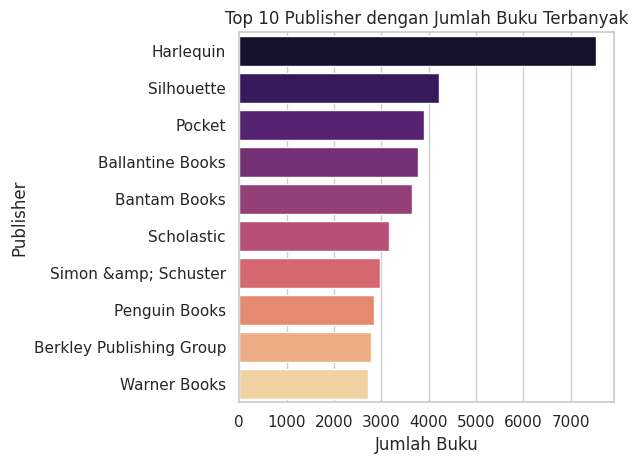

In [43]:
top_publishers = books['Publisher'].value_counts().head(10)

sns.barplot(x=top_publishers.values, y=top_publishers.index, palette='magma')
plt.title("Top 10 Publisher dengan Jumlah Buku Terbanyak")
plt.xlabel("Jumlah Buku")
plt.ylabel("Publisher")
plt.tight_layout()
plt.show()


- Beberapa penerbit besar seperti Harlequin, Penguin Books, atau Scholastic Inc. mendominasi jumlah buku.


## **2.5. Distribusi Ratings**

<ipython-input-44-0b22444a274c>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Book-Rating', data=ratings, palette='coolwarm')


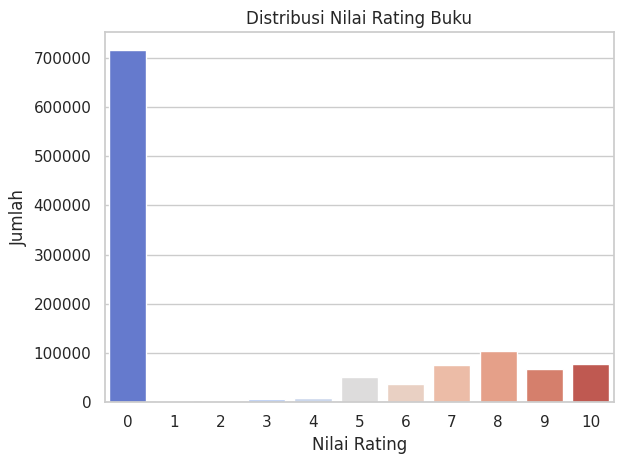

In [44]:
sns.countplot(x='Book-Rating', data=ratings, palette='coolwarm')
plt.title("Distribusi Nilai Rating Buku")
plt.xlabel("Nilai Rating")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()

- Rating 0 sangat mendominasi → ini kemungkinan besar bukan rating nyata, tetapi interaksi tanpa evaluasi (implicit feedback).

- Rentang rating 1–10 cukup bervariasi dan menunjukkan penggunaan eksplisit sistem rating.


# **3. Data Preparation**

#### **3.1. Penyesuaian Nama Kolom**

In [45]:
# --- Penyesuaian Nama Kolom agar konsisten---
print("\n--- Menyesuaikan Nama Kolom ---")
users.columns = ['User_ID', 'Location', 'Age']
books.columns = ['ISBN', 'Book_Title', 'Book_Author', 'Year_Of_Publication', 'Publisher', 'Image_URL_S', 'Image_URL_M', 'Image_URL_L']
ratings.columns = ['User_ID', 'ISBN', 'Book_Rating']

print("Nama kolom Users:", users.columns.tolist())
print("Nama kolom Books:", books.columns.tolist())
print("Nama kolom Ratings:", ratings.columns.tolist())


--- Menyesuaikan Nama Kolom ---
Nama kolom Users: ['User_ID', 'Location', 'Age']
Nama kolom Books: ['ISBN', 'Book_Title', 'Book_Author', 'Year_Of_Publication', 'Publisher', 'Image_URL_S', 'Image_URL_M', 'Image_URL_L']
Nama kolom Ratings: ['User_ID', 'ISBN', 'Book_Rating']


- Konsistensi nama kolom sangat penting untuk meningkatkan keterbacaan dan mempermudah pengolahan data.

- Kolom dibuat seragam agar mudah dipahami juga dan mengurangi kemungkinan error saat join, merge, dan transformasi data.

#### **3.2. Membersihkan Dataset Books**

In [46]:
print(f"Jumlah data Books Sebelum persiapan: {books.shape}")

Jumlah data Books Sebelum persiapan: (271360, 8)


###### **3.2.1. Menghapus kolom URL**

Kolom URL gambar dihapus karena tidak berkontribusi langsung terhadap rekomendasi berbasis rating atau konten

In [47]:
# Menghapus kolom URL gambar
books.drop(['Image_URL_S', 'Image_URL_M', 'Image_URL_L'], axis=1, inplace=True)
print("Kolom URL gambar dihapus.")

Kolom URL gambar dihapus.


###### **3.2.2. Menangani Missing Value**

Menghapus missing value pada kolom books_Author dan Publisher

In [48]:
# Book-Author dan Publisher (hanya sedikit missing values)
print(f"Missing values di Book_Author sebelum penghapusan: {books['Book_Author'].isnull().sum()}")
print(f"Missing values di Publisher sebelum penghapusan: {books['Publisher'].isnull().sum()}")

books.dropna(subset=['Book_Author', 'Publisher'], inplace=True) # Menghapus baris dengan missing values

print(f"Missing values di Book_Author setelah penghapusan: {books['Book_Author'].isnull().sum()}")
print(f"Missing values di Publisher setelah penghapusan: {books['Publisher'].isnull().sum()}")


Missing values di Book_Author sebelum penghapusan: 2
Missing values di Publisher sebelum penghapusan: 2
Missing values di Book_Author setelah penghapusan: 0
Missing values di Publisher setelah penghapusan: 0


Karena jumlah data kosong kecil, jadi lebih baik langsung dihapus untuk menjaga kualitas data.

###### **3.2.3. Mengubah tipe data**

Mengubah tipe data Year_Of_Publication ke integer agar data bisa diproses,

In [49]:
# Year-Of-Publication
print(f"Tipe data Year_Of_Publication sebelum: {books['Year_Of_Publication'].dtype}")

# Konversi ke numerik, paksa error menjadi NaN
books['Year_Of_Publication'] = pd.to_numeric(books['Year_Of_Publication'], errors='coerce')

# Hapus baris dengan NaN di Year_Of_Publication setelah konversi (jika ada yang tidak bisa dikonversi)
books.dropna(subset=['Year_Of_Publication'], inplace=True)

# Ubah ke integer
books['Year_Of_Publication'] = books['Year_Of_Publication'].astype(int)

print(f"Tipe data Year_Of_Publication setelah: {books['Year_Of_Publication'].dtype}")



Tipe data Year_Of_Publication sebelum: float64
Tipe data Year_Of_Publication setelah: int64


###### **3.2.4. Menangani Outliers**

- Membersihkan rentang tahun sebelum 1900 dan setelah masa kini, meningkatkan validitas fitur dan mencegah noise dalam data.

Ini juga penting untuk analisis tren penerbitan buku dari waktu ke waktu.

In [50]:
# Membersihkan tahun yang tidak valid
current_year = pd.to_datetime('today').year

# Asumsi buku tidak diterbitkan sebelum tahun 1900 Masehi atau setelah tahun ini
books = books[(books['Year_Of_Publication'] > 1900) & (books['Year_Of_Publication'] <= current_year)]
print(f"Rentang Year_Of_Publication setelah dibersihkan: {books['Year_Of_Publication'].min()} - {books['Year_Of_Publication'].max()}")
print(f"Tipe data Year_Of_Publication setelah diubah: {books['Year_Of_Publication'].dtype}")



Rentang Year_Of_Publication setelah dibersihkan: 1901 - 2024
Tipe data Year_Of_Publication setelah diubah: int64


###### **3.2.5. Menghapus baris tanpa judul buku**

In [51]:
# Book_Title dicek dan di hapus jika ada NaN
books.dropna(subset=['Book_Title'], inplace=True)

print(f"Jumlah data Books setelah persiapan: {books.shape}")

Jumlah data Books setelah persiapan: (266716, 5)


<ipython-input-51-29cf554feba5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books.dropna(subset=['Book_Title'], inplace=True)


In [52]:
print(f"Jumlah data Books setelah persiapan: {books.shape}")

Jumlah data Books setelah persiapan: (266716, 5)


Total data books setelah tahap persiapan adalah: 266.721

#### **3.3. Mempersiapan Dataset Users**

###### **3.3.1. Menangani Missing Value**

In [53]:
print("\n--- Mempersiapkan Dataset Pengguna ---")
print(f"Missing values di Age sebelum ditangani: {users['Age'].isnull().sum()} ({users['Age'].isnull().mean()*100:.2f}%)")
# Mengisi NaN dengan median
median_age = users['Age'].median()
users['Age'].fillna(median_age, inplace=True)
print(f"Missing values di Age setelah imputasi median: {users['Age'].isnull().sum()}")



--- Mempersiapkan Dataset Pengguna ---
Missing values di Age sebelum ditangani: 110762 (39.72%)
Missing values di Age setelah imputasi median: 0


<ipython-input-53-b164bdadfc96>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  users['Age'].fillna(median_age, inplace=True)


Menangani missing value dengan median

Menggunakan median lebih tahan terhadap outlier dibanding mean, dan menjaga distribusi data agar tetap realistis.

###### **3.3.2. Menangani Outliers**

In [54]:
# Menangani usia yang tidak realistis (misal < 5 atau > 100), ganti dengan median
users.loc[users['Age'] < 5, 'Age'] = median_age
users.loc[users['Age'] > 100, 'Age'] = median_age
print(f"Rentang Age setelah penanganan outlier: {users['Age'].min()} - {users['Age'].max()}")

Rentang Age setelah penanganan outlier: 5.0 - 100.0


- Usia di bawah 5 dan di atas 100 jarang terjadi dan kemungkinan merupakan data error atau manipulasi pengguna.

- Usia dibawah 5 tahun dan di atas 100 tahun di ganti dengan nilai median agar data tidak dibuang, tapi tetap valid secara statistik.

###### **3.3.3. Konversi Tipe data Age**

In [55]:
# Konversi Age ke integer
users['Age'] = users['Age'].astype(int)
print(f"Tipe data Age setelah diubah: {users['Age'].dtype}")

Tipe data Age setelah diubah: int64


###### **3.3.4. Mengubah tipe data Age ke integer**

In [56]:
print(f"Jumlah Data Users setelah persiapan: {users.shape}")

Jumlah Data Users setelah persiapan: (278858, 3)


Humlah data User setelah melalui tahap persiapan adalah 278.858

#### **3.4. Mempersiapkan Dataset Ratings**

###### **3.4.1. Mensinkronkan data Ratings dengan Books dan Users**

In [57]:
# --- Mempersiapkan Dataset Ratings ---
print("\n--- Mempersiapkan Dataset Rating ---")
# Memastikan ISBN di ratings ada di books_df yang sudah bersih
ratings = ratings[ratings['ISBN'].isin(books['ISBN'])]
# Memastikan User_ID di ratings ada di users yang sudah bersih
ratings = ratings[ratings['User_ID'].isin(users['User_ID'])]
print(f"Jumlah data Ratings setelah sinkronisasi dengan books dan users: {ratings.shape}")


--- Mempersiapkan Dataset Rating ---
Jumlah data Ratings setelah sinkronisasi dengan books dan users: (1017058, 3)


Total data setelah di sinkronkan adalah 1.017.058

#### **3.5. Filtering Data**

###### **3.5.1. Mengambil rating eksplisit**

In [58]:
print("\n--- Filter Rating untuk Collaborative Filtering ---")

# Mengambil hanya rating eksplisit (1–10)
ratings_explicit = ratings[ratings['Book_Rating'] != 0]
print(f"Rating eksplisit: {len(ratings_explicit)}")


--- Filter Rating untuk Collaborative Filtering ---
Rating eksplisit: 378026


Hanya rating eksplisit (bernilai 1–10) yang digunakan karena Collaborative Filtering (CF) membutuhkan interaksi yang jelas. Rating = 0 biasanya berarti implicit feedback.

Jumlah data: len(ratings_explicit) menunjukkan total interaksi yang valid dan bisa digunakan oleh model CF.

###### **3.5.2. Filter Pengguna Aktif**

In [59]:
# Filter pengguna aktif yang memberikan rating (≥5 rating)
active_users = ratings_explicit['User_ID'].value_counts()
active_users = active_users[active_users >= 5].index
ratings_filtered = ratings_explicit[ratings_explicit['User_ID'].isin(active_users)]
print(f"Rating setelah filter pengguna: {len(ratings_filtered)}")
print(f"Pengguna aktif: {len(active_users)}")

Rating setelah filter pengguna: 297648
Pengguna aktif: 12616


Pengguna yang hanya memberikan sedikit rating tidak memberikan informasi cukup bagi model CF untuk memahami preferensinya. Dengan menyaring hanya pengguna yang aktif (setidaknya 5 rating), kita:

- Meningkatkan kualitas data.

- Mengurangi noise dari pengguna pasif.

###### **3.5.3. Filter Buku Populer**

In [60]:
# Filter buku populer (≥10 rating)
popular_books = ratings_filtered['ISBN'].value_counts()
popular_books = popular_books[popular_books >= 10].index
final_ratings = ratings_filtered[ratings_filtered['ISBN'].isin(popular_books)]
print(f"Rating setelah filter buku: {len(final_ratings)}")
print(f"Buku populer: {final_ratings['ISBN'].nunique()}")
print(f"Pengguna unik: {final_ratings['User_ID'].nunique()}")

Rating setelah filter buku: 92365
Buku populer: 3942
Pengguna unik: 11161


Buku yang hanya mendapatkan sedikit rating sulit dipelajari oleh model karena datanya minim. Dengan menyaring buku yang mendapatkan minimal 10 rating:

- Model bisa mempelajari pola preferensi terhadap buku tersebut dengan lebih akurat.

- Menghindari overfitting terhadap item yang jarang dinilai.

###### **3.5.4. Sinkronkan ulang dataset Users dan Books**

In [61]:
# Sinkronisasi buku & pengguna
books_final = books[books['ISBN'].isin(final_ratings['ISBN'])]
users_final = users[users['User_ID'].isin(final_ratings['User_ID'])]

print("\nBentuk akhir untuk Collaborative Filtering:")
print(f"  Ratings: {final_ratings.shape}")
print(f"  Books: {books_final.shape}")
print(f"  Users: {users_final.shape}")


Bentuk akhir untuk Collaborative Filtering:
  Ratings: (92365, 3)
  Books: (3942, 5)
  Users: (11161, 3)


Hanya buku dan pengguna yang masih relevan dengan final_ratings yang disertakan dalam model. Ini penting agar:

Tidak ada entitas “asing” di saat pelatihan model.

Dataset menjadi lebih ringan dan relevan.

#### **3.6. Menggabungkan Data**

Menggabungkan data ratings dengan books dan users

In [62]:
# Menggabungkan final_ratings dengan books dan users
merged_df = final_ratings.merge(books_final, on='ISBN').merge(users_final, on='User_ID')
print(f"Bentuk data gabungan (ratings + books + users): {merged_df.shape}")
print(merged_df.head())

Bentuk data gabungan (ratings + books + users): (92365, 9)
   User_ID        ISBN  Book_Rating                           Book_Title  \
0   276747  0060517794            9             Little Altars Everywhere   
1   276747  0671537458            9                    Waiting to Exhale   
2   276747  0679776818            8    Birdsong: A Novel of Love and War   
3   276822  0060096195           10                    The Boy Next Door   
4   276822  0786817070           10  Artemis Fowl (Artemis Fowl, Book 1)   

        Book_Author  Year_Of_Publication          Publisher  \
0     Rebecca Wells                 2003        HarperTorch   
1    Terry McMillan                 1995             Pocket   
2  Sebastian Faulks                 1997  Vintage Books USA   
3      Meggin Cabot                 2002         Avon Trade   
4       Eoin Colfer                 2002       Miramax Kids   

                   Location  Age  
0      iowa city, iowa, usa   25  
1      iowa city, iowa, usa   25  


Data setelah digabungkan Memiliki:
- Jumlah baris: 92,365
  
  Ini mewakili jumlah interaksi unik antara pengguna dan buku — artinya ada 92.365 rating eksplisit yang telah diberikan oleh pengguna aktif terhadap buku-buku populer.

- Jumlah kolom: 9
  
  Setiap baris memiliki informasi dari tiga sumber data:

  - ratings (User_ID, ISBN, Book_Rating)

  - books (Book_Title, Book_Author, Year_Of_Publication, Publisher)

  - users (Location, Age)

#### **3.7. Buat Dataset Content-Based**

In [63]:
# Buat Dataset Content-Based dari merged_df

books_cb = merged_df[['ISBN', 'Book_Title', 'Book_Author', 'Publisher']].drop_duplicates(subset='ISBN')
books_cb = books_cb.fillna('')
books_cb['content_features'] = (books_cb['Book_Title'] + ' ' + books_cb['Book_Author'] + ' ' + books_cb['Publisher']).str.lower()

print("Jumlah buku unik (Content-Based):", books_cb.shape[0])



Jumlah buku unik (Content-Based): 3942


Penjelasan:
- Dataset books_cb dibuat dari merged_df dengan hanya mempertahankan kolom yang relevan untuk analisis berbasis konten: Book_Title, Book_Author, dan Publisher.

- Baris dengan ISBN duplikat dihapus karena setiap ISBN mewakili buku unik.

- Semua teks dikonversi menjadi lowercase dan digabung untuk membentuk satu fitur gabungan: content_features.

Dataset akhir memiliki fitur berbasis teks yang mewakili deskripsi konten tiap buku. Ini akan digunakan untuk menghitung kemiripan antar buku.



#### **3.8. Vektorisasi dengan TF-IDF**

In [64]:
# TF-IDF Vectorization

tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(books_cb['content_features'])

print("TF-IDF Matrix shape:", tfidf_matrix.shape)

TF-IDF Matrix shape: (3942, 17897)


Penjelasan:
- Menggunakan TF-IDF untuk mengubah data teks menjadi vektor numerik.

- `stop_words='english'` menghapus kata umum (seperti the, and, dll).

- `ngram_range=(1,2)` mempertimbangkan kata tunggal (unigram) dan pasangan kata (bigram) untuk konteks yang lebih baik.

TF-IDF menangkap kata-kata penting dari judul, penulis, dan penerbit. Ini membantu sistem memahami karakteristik unik dari setiap buku berdasarkan teks deskriptif.

#### **3.9. Splitting Data untuk Collaborative Filtering (Surprise)**

Untuk Collaborative Filtering, kita akan menggunakan library scikit-surprise. Library ini memerlukan data dalam format spesifik. Kita membuat objek Reader untuk mendefinisikan skala rating dari (1 hingga 10, sesuai dataset ratings) dan kemudian memuat data User_ID, ISBN, dan Book_Rating ke dalam objek Dataset Surprise.

In [65]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(final_ratings[['User_ID', 'ISBN', 'Book_Rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)


- Data rating telah disiapkan dalam format yang sesuai untuk pemodelan collaborative filtering menggunakan Surprise.

- Rating eksplisit 1–10 memungkinkan kita membangun model prediksi dengan granularitas tinggi.

- Splitting 80:20 memastikan proses validasi model dilakukan secara terkontrol dan dapat direproduksi.

# **4. Exploratory Data Analysis Lanjutan (EDA)**

Visualisasi Ini adalah tahapan lanjutan untuk memahami data setelah melalui data preparation

#### **4.1. Distribusi Tahun Publikasi Buku**

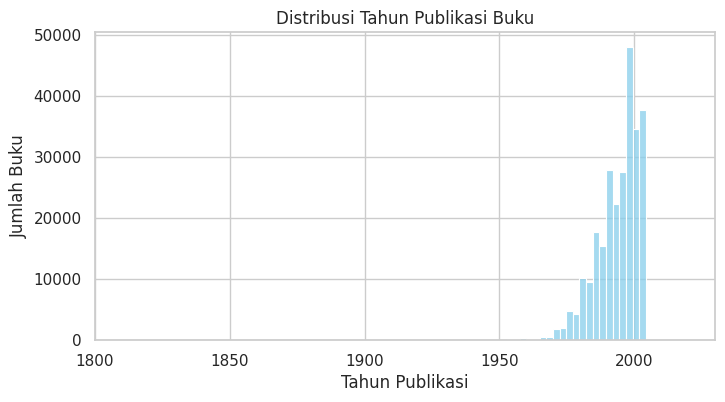

In [66]:
plt.figure(figsize=(8, 4))
sns.histplot(books['Year_Of_Publication'], bins=50, color='skyblue')
plt.title('Distribusi Tahun Publikasi Buku')
plt.xlabel('Tahun Publikasi')
plt.ylabel('Jumlah Buku')
plt.xlim(1800, pd.to_datetime('today').year + 5)
plt.show()


Mayoritas buku terbit setelah tahun 1950, menunjukkan dominasi koleksi buku modern dalam dataset. Outlier di bawah tahun 1900 sangat sedikit, kemungkinan merupakan kesalahan input.

#### **4.2. Distribusi Usia Pengguna**

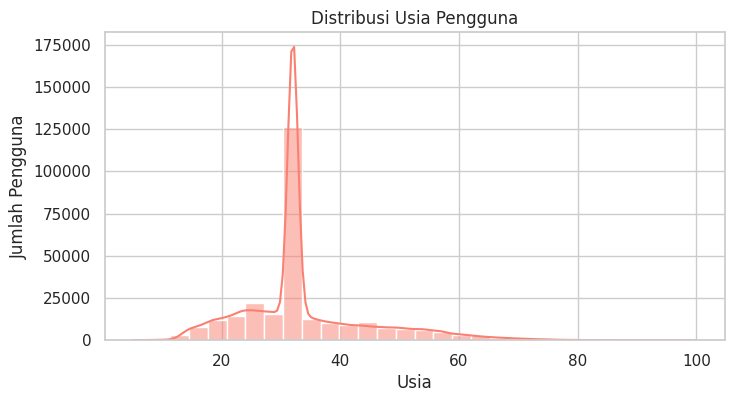

In [67]:
plt.figure(figsize=(8, 4))
sns.histplot(users['Age'], bins=30, kde=True, color='salmon')
plt.title('Distribusi Usia Pengguna')
plt.xlabel('Usia')
plt.ylabel('Jumlah Pengguna')
plt.show()

Sebagian besar pengguna berusia antara 20–40 tahun, menandakan dominasi pengguna dewasa muda yang kemungkinan aktif dalam membaca dan memberikan rating.

#### **4.3 Distribusi Rating Eksplisit**

<ipython-input-68-a102b5adbd26>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Book_Rating', data=ratings_explicit, palette='viridis')


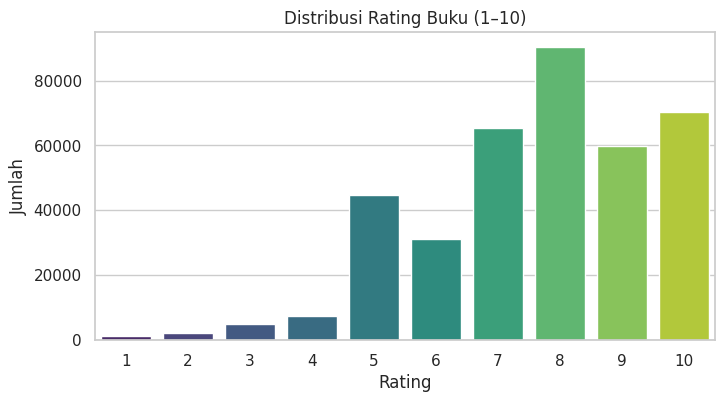

In [68]:
plt.figure(figsize=(8, 4))
sns.countplot(x='Book_Rating', data=ratings_explicit, palette='viridis')
plt.title('Distribusi Rating Buku (1–10)')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

Rating 8, 9, dan 10 mendominasi, menunjukkan bias pengguna terhadap memberikan rating tinggi. Rating rendah (1–3) sangat jarang.

#### **4.4. Jumlah Rating Selama Proses Filtering**

<ipython-input-69-c3dd9734c7eb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette='coolwarm')


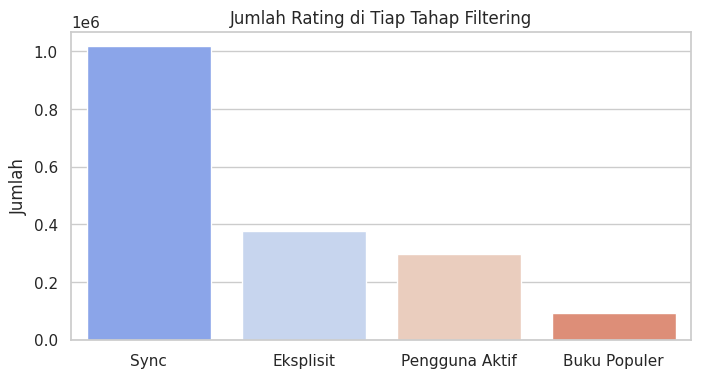

In [69]:
plt.figure(figsize=(8, 4))
counts = [1017064, len(ratings_explicit), len(ratings_filtered), len(final_ratings)]
labels = ['Sync', 'Eksplisit', 'Pengguna Aktif', 'Buku Populer']
sns.barplot(x=labels, y=counts, palette='coolwarm')
plt.title('Jumlah Rating di Tiap Tahap Filtering')
plt.ylabel('Jumlah')
plt.show()

Terjadi penurunan drastis dari total rating ke rating buku populer yang digunakan, menandakan pentingnya filtering untuk menjaga kualitas data input.

#### **4.5. Distribusi Rating per Pengguna**

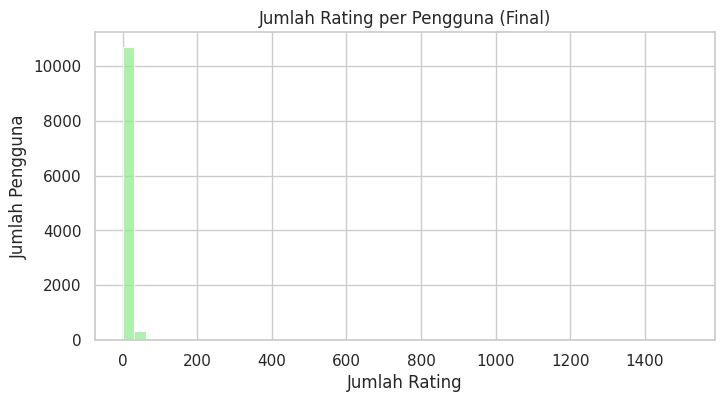

In [70]:
plt.figure(figsize=(8, 4))
sns.histplot(final_ratings['User_ID'].value_counts(), bins=50, color='lightgreen')
plt.title('Jumlah Rating per Pengguna (Final)')
plt.xlabel('Jumlah Rating')
plt.ylabel('Jumlah Pengguna')
plt.show()

Sebagian besar pengguna aktif memberikan sekitar 5–20 rating. Hanya sedikit pengguna yang memberikan rating dalam jumlah besar (50+).

#### **4.6. Distribusi Rating per Buku**

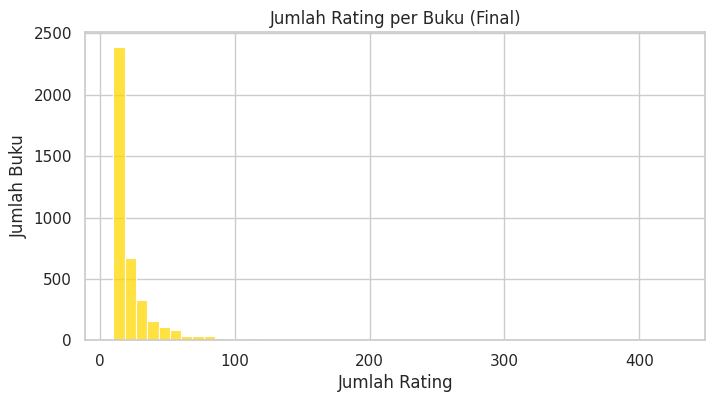

In [71]:
plt.figure(figsize=(8, 4))
sns.histplot(final_ratings['ISBN'].value_counts(), bins=50, color='gold')
plt.title('Jumlah Rating per Buku (Final)')
plt.xlabel('Jumlah Rating')
plt.ylabel('Jumlah Buku')
plt.show()

Buku dengan jumlah rating yang sangat tinggi relatif sedikit. Mayoritas buku populer memiliki 10–30 rating.

#### **4.7. Distribusi Rating pada Data Gabungan**

<ipython-input-72-622af8c59af0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Book_Rating', data=merged_df, palette='crest')


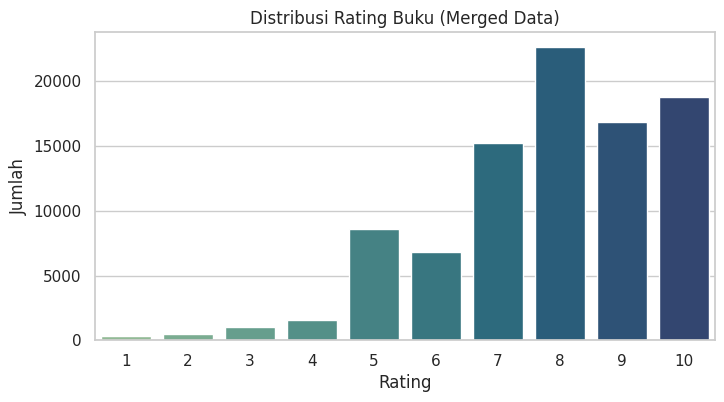

In [72]:
plt.figure(figsize=(8, 4))
sns.countplot(x='Book_Rating', data=merged_df, palette='crest')
plt.title('Distribusi Rating Buku (Merged Data)')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()


Distribusi tetap menunjukkan dominasi rating tinggi, mengindikasikan konsistensi preferensi pengguna meskipun data digabung.

#### **4.8. Top 10 Penulis (Collaborative Filtering)**

<ipython-input-73-2a05106787bb>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_authors_cf.index, x=top_authors_cf.values, palette='mako')


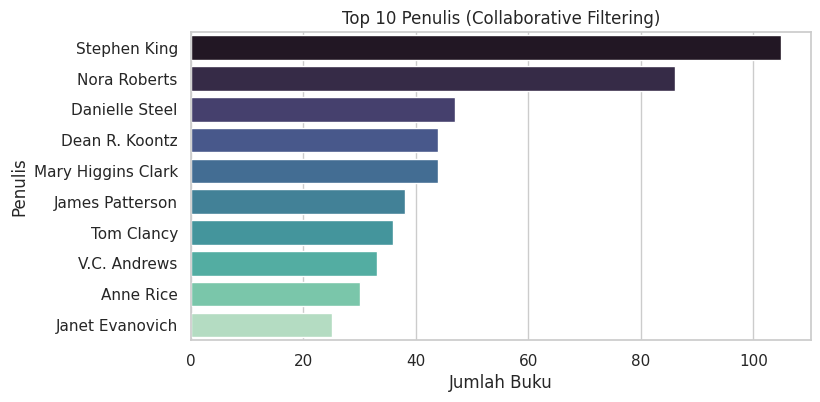

In [73]:
plt.figure(figsize=(8, 4))
top_authors_cf = books_final['Book_Author'].value_counts().nlargest(10)
sns.barplot(y=top_authors_cf.index, x=top_authors_cf.values, palette='mako')
plt.title('Top 10 Penulis (Collaborative Filtering)')
plt.xlabel('Jumlah Buku')
plt.ylabel('Penulis')
plt.show()


Penulis populer ini kemungkinan besar merupakan kandidat kuat untuk sistem rekomendasi berbasis kolaboratif karena banyaknya interaksi dengan pengguna.

#### **4.9. Top 10 Penulis (Content-Based)**

<ipython-input-74-7ac012308a67>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_authors_cb.index, x=top_authors_cb.values, palette='flare')


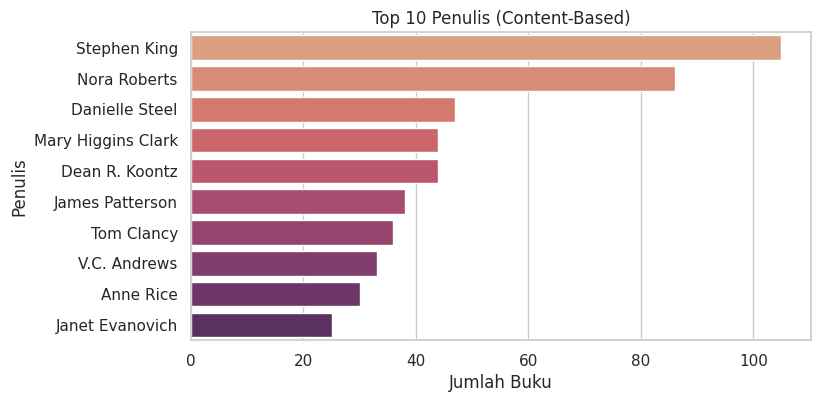

In [74]:
plt.figure(figsize=(8, 4))
top_authors_cb = books_cb['Book_Author'].value_counts().nlargest(10)
sns.barplot(y=top_authors_cb.index, x=top_authors_cb.values, palette='flare')
plt.title('Top 10 Penulis (Content-Based)')
plt.xlabel('Jumlah Buku')
plt.ylabel('Penulis')
plt.show()


Penulis ini memiliki volume buku tinggi dalam data, menjadikan mereka cocok untuk sistem berbasis konten (genre, gaya tulisan, dsb).

# **5. Modeling**

## **5.1. Modeling: Content Based Filtering**

#### **5.1.1. Cosine Similarity**

In [75]:
# Hitung Cosine Similarity

if tfidf_matrix.shape[0] == 0:
    print("TF-IDF Matrix kosong, tidak dapat menghitung cosine similarity.")
    similarity_matrix = None
else:
    similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
    print("Cosine Similarity Matrix shape:", similarity_matrix.shape)



Cosine Similarity Matrix shape: (3942, 3942)


Penjelasan:
- Cosine Similarity digunakan untuk mengukur tingkat kemiripan antara setiap buku berdasarkan vektor TF-IDF.

- Matriks `similarity_matrix[i][j]` menunjukkan seberapa mirip buku ke-i dengan buku ke-j.

Semakin tinggi nilai cosine similarity (maksimal 1), semakin mirip konten antara dua buku. Matriks ini adalah dasar sistem rekomendasi.



#### **5.1.2. Mapping Judul ke Index**

In [76]:
# Buat Mapping Judul → Index

title_idx_map = pd.Series(range(len(books_cb)), index=books_cb['Book_Title']).drop_duplicates()

Penjelasan:
- Membuat mapping dari Book_Title ke index dalam dataframe `books_cb`.

- Memudahkan pencarian posisi vektor buku tertentu untuk di-referensikan dalam `similarity_matrix`.

Dengan mapping ini, kita dapat langsung mencari skor kemiripan untuk buku manapun tanpa perlu mencarinya satu per satu secara manual.

#### **5.1.3. Rekomendasi Berdasarkan Kemiripan Konten**

In [77]:
# Ambil contoh judul (ganti sesuai keinginan)
sample_index = 10
top_n = 5
sample_title = books_cb['Book_Title'].iloc[sample_index]

# Pastikan judul tersedia
if sample_title not in title_idx_map:
    possible_matches = [t for t in title_idx_map.index if sample_title.lower() in t.lower()]
    if not possible_matches:
        print(f"Buku '{sample_title}' tidak ditemukan.")
    else:
        print(f"Judul tidak ditemukan. Mungkin maksud Anda: {possible_matches[:3]}")
        sample_title = possible_matches[0]

# Ambil index dan skor kemiripan
idx = title_idx_map[sample_title]
sim_scores = list(enumerate(similarity_matrix[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
book_indices = [i[0] for i in sim_scores]


Penjelasan:
- Sistem mengambil satu judul sebagai input, mencari skor kemiripan terhadap semua buku lainnya, dan mengurutkan skor tersebut.

- Menghindari self-match (hasil pertama di-skip karena itu adalah buku itu sendiri).

- Top N buku yang paling mirip ditampilkan sebagai rekomendasi.

Rekomendasi yang dihasilkan berdasarkan kemiripan konten cocok untuk pengguna baru yang belum banyak memberikan rating (cold-start). Sistem ini juga bisa membantu pengguna menemukan buku dengan tema, penulis, atau penerbit yang serupa.

In [78]:
# Tampilkan hasil rekomendasi
recommendations = books_cb.iloc[book_indices][['Book_Title', 'Book_Author', 'ISBN']].copy()
recommendations['similarity_score'] = [s[1] for s in sim_scores]

print(f"\n Rekomendasi untuk buku: '{sample_title}' (Top {top_n})")
print(recommendations)


 Rekomendasi untuk buku: 'Politically Correct Bedtime Stories: Modern Tales for Our Life and Times' (Top 5)
                                             Book_Title        Book_Author  \
8787  Politically Correct Holiday Stories: For an En...  James Finn Garner   
153   Once upon a More Enlightened Time: More Politi...  James Finn Garner   
1264  Wicked : The Life and Times of the Wicked Witc...    Gregory Maguire   
467   Wicked: The Life and Times of the Wicked Witch...    Gregory Maguire   
6580            The Canterbury Tales, in Modern English   Geoffrey Chaucer   

            ISBN  similarity_score  
8787  0028604202          0.559432  
153   0028604199          0.480889  
1264  0060391448          0.114175  
467   0060987103          0.111192  
6580  0140440224          0.075267  


## **5.2. Modeling: Collaborative Filtering (SVD dengan Surprise)**

Collaborative Filtering memanfaatkan kemiripan antar pengguna berdasarkan perilaku rating untuk merekomendasikan item. Pendekatan ini sangat cocok untuk mempersonalisasi rekomendasi berdasarkan interaksi pengguna lain yang memiliki preferensi serupa

#### **5.2.1. Melatih Model SVD**

In [79]:
algo_svd = SVD(n_factors=50, n_epochs=30, biased=True, lr_all=0.005, reg_all=0.01)
print("Training SVD model...")
algo_svd.fit(trainset)


Training SVD model...


Penjelasan:

- Menggunakan algoritma SVD yang memfaktorisasi matriks user-item menjadi faktor laten.

- Parameter seperti n_factors, lr_all, dan reg_all bisa dioptimasi lebih lanjut dengan Grid Search.

- SVD efektif untuk mengatasi sparsity (ketiadaan rating) dan cocok untuk dataset skala menengah hingga besar.

#### **5.2.2. Membuat Prediksi pada Test Set**

Setelah model dilatih, kita menggunakannya untuk membuat prediksi rating pada testset (20% data yang disisihkan). Hasil prediksi ini (predictions). Data predictions ini akan digunakan pada tahap Evaluasi untuk menghitung metrik RMSE dan MAE, yang mengukur seberapa akurat prediksi model kita

In [80]:
print("Making predictions on test set...")
predictions = algo_svd.test(testset)

print("--- Collaborative Filtering Modeling Complete ---")

Making predictions on test set...
--- Collaborative Filtering Modeling Complete ---


# **6. Fungsi Rekomendasi**

Setelah model-model kita dilatih, langkah selanjutnya adalah membuat fungsi-fungsi praktis yang dapat digunakan untuk menghasilkan dan menampilkan rekomendasi film kepada pengguna. Kita akan membuat fungsi terpisah untuk Content-Based Filtering dan Collaborative Filtering.

## **6.1. Fungsi Content-Based-Filtering**

Fungsi get_content_based_recommendations digunakan untuk merekomendasikan buku berdasarkan kemiripan kontennya (judul, penulis, penerbit). Fungsi ini mengambil judul buku sebagai input, mencari skor kemiripan dari matriks cosine similarity, lalu mengembalikan daftar buku yang paling mirip (top-N), lengkap dengan skor kemiripan.

Jika judul tidak ditemukan, fungsi akan menangani error dengan memberikan pesan yang sesuai.


In [81]:
def get_content_based_recommendations(title, books_cb, similarity_matrix, title_idx_map, N=10):
    """
    Fungsi inti untuk mendapatkan rekomendasi Content-Based Filtering (mengembalikan DataFrame).
    """
    try:
        # Ambil index buku berdasarkan judul
        book_id_or_series = title_idx_map[title]

        if isinstance(book_id_or_series, pd.Series):
            book_id = book_id_or_series.iloc[0]
        else:
            book_id = book_id_or_series

        idx = books_cb.index.get_loc(book_id)

        sim_scores = list(enumerate(similarity_matrix[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:N+1]  # skip self-match
        book_indices = [i[0] for i in sim_scores]

        recommended_book_ids = books_cb.iloc[book_indices].index
        recommendations = books_cb.loc[recommended_book_ids].copy()
        recommendations['Similarity Score'] = [score[1] for score in sim_scores]
        return recommendations[['Book_Title', 'Book_Author', 'Publisher', 'Similarity Score']]

    except KeyError:
        return f"Buku dengan judul '{title}' tidak ditemukan."

Fungsi display_readable_cb_recommendations dirancang untuk menyajikan hasil rekomendasi buku berbasis konten dalam format yang rapi dan mudah dipahami oleh pengguna. Fungsi ini bekerja dengan mengambil judul buku sebagai input, lalu memanggil fungsi rekomendasi utama untuk mendapatkan daftar buku yang paling mirip berdasarkan kontennya. Setelah itu, hasil rekomendasi diformat ulang: indeks direset agar mulai dari 1, skor kemiripan ditampilkan hingga tiga desimal, dan hasil akhir dicetak dalam bentuk tabel lengkap dengan peringkat. Jika judul buku tidak ditemukan, fungsi ini juga menangani error dengan menampilkan pesan yang sesuai. Tujuan utama dari fungsi ini adalah menyampaikan hasil rekomendasi dengan cara yang jelas dan informatif bagi pengguna.

In [82]:
def display_readable_cb_recommendations(title, books_cb, similarity_matrix, title_idx_map, N=5):
    """
    Menampilkan hasil rekomendasi Content-Based dalam format tabel yang mudah dibaca.
    """
    print("-" * 70)
    print(f"Rekomendasi Content-Based untuk '{title}':")
    print("-" * 70)

    recommendations_df = get_content_based_recommendations(title, books_cb, similarity_matrix, title_idx_map, N=N)

    if isinstance(recommendations_df, str):
        print(recommendations_df)
    else:
        readable_df = recommendations_df.reset_index(drop=True)
        readable_df.index = readable_df.index + 1
        readable_df = readable_df.rename_axis('Rank').reset_index()
        readable_df['Similarity Score'] = readable_df['Similarity Score'].map('{:,.3f}'.format)
        print(readable_df.to_string(index=False))

    print("-" * 70)
    print("\n")


## **6.2. Fungsi: Collaborative Filtering (SVD)**

Fungsi get_top_n_collaborative_recommendations bertujuan untuk menghasilkan daftar rekomendasi buku terbaik bagi setiap pengguna berdasarkan pendekatan Collaborative Filtering. Fungsi ini menerima input berupa daftar prediksi dari model (yang telah memprediksi rating yang mungkin diberikan pengguna terhadap buku-buku tertentu), kemudian mengelompokkan prediksi tersebut berdasarkan ID pengguna (uid).

Untuk setiap pengguna, fungsi akan menyusun daftar buku beserta rating prediksi (est), mengurutkannya dari yang tertinggi ke terendah, dan mengambil Top-N buku dengan prediksi rating terbaik. Hasil akhirnya adalah sebuah dictionary (kamus), di mana kunci (key)-nya adalah ID pengguna, dan nilainya adalah daftar rekomendasi buku beserta prediksi rating-nya. Fungsi ini menjadi dasar sistem rekomendasi personal yang memanfaatkan preferensi pengguna lain yang serupa.

In [83]:
def get_top_n_collaborative_recommendations(predictions, n=10):
    """
    Fungsi untuk mendapatkan top-N rekomendasi dari Collaborative Filtering.
    """
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


Fungsi display_collaborative_recommendations digunakan untuk menampilkan rekomendasi buku berdasarkan pendekatan Collaborative Filtering yang telah dihitung sebelumnya. Fungsi ini menerima input berupa user_id, dictionary hasil prediksi (top_n_dict), dan DataFrame buku (books_df).

Fungsi ini akan mengecek apakah ID pengguna tersedia dalam hasil rekomendasi. Jika ada, maka fungsi akan menampilkan daftar Top-N buku yang direkomendasikan lengkap dengan ISBN, skor prediksi rating, dan judul bukunya. Setiap rekomendasi diberi peringkat agar mudah dibaca. Jika user ID tidak ditemukan, maka akan ditampilkan pesan bahwa pengguna tidak tersedia.

Dengan tampilan yang terstruktur dan rapi, fungsi ini sangat berguna untuk menyajikan hasil rekomendasi secara informatif kepada pengguna.

In [84]:
def display_collaborative_recommendations(user_id, top_n_dict, books_df, N=5):
    """
    Menampilkan top-N rekomendasi untuk user tertentu dari hasil prediksi SVD.
    """
    print("-" * 70)
    print(f"Rekomendasi Collaborative Filtering untuk User {user_id}:")
    print("-" * 70)

    if user_id in top_n_dict:
        recommendations = top_n_dict[user_id][:N]
        print(f"{'Rank':<5} {'ISBN':<15} {'Predicted Rating':<17} {'Book Title'}")
        print("-" * 70)

        for i, (isbn, pred_rating) in enumerate(recommendations, 1):
            book_title = books_df[books_df['ISBN'] == isbn]['Book_Title']
            title = book_title.iloc[0] if not book_title.empty else "Unknown Title"
            print(f"{i:<5} {isbn:<15} {pred_rating:<17.3f} {title}")
    else:
        print(f"User {user_id} tidak ditemukan dalam rekomendasi.")

    print("-" * 70)
    print("\n")


# **7. Evaluasi Model**

## **7.1. Evaluasi Collaborative Filtering**

In [85]:
# Evaluasi dengan RMSE dan MAE
rmse = accuracy.rmse(predictions, verbose=True)
mae = accuracy.mae(predictions, verbose=True)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


RMSE: 1.5831
MAE:  1.2115
Root Mean Squared Error (RMSE): 1.5831
Mean Absolute Error (MAE): 1.2115


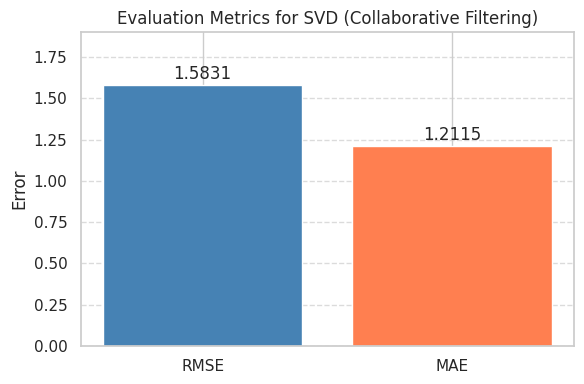

In [86]:
# Visualisasi Evaluasi CF
metrics = ['RMSE', 'MAE']
values = [rmse, mae]

plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values, color=['steelblue', 'coral'])
plt.title('Evaluation Metrics for SVD (Collaborative Filtering)')
plt.ylabel('Error')
plt.ylim(0, max(values)*1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## **7.2. Evaluasi Content Based Filtering**

In [87]:
def evaluate_content_based(books_cb, similarity_matrix, title_idx_map, ratings_test_df, top_n=5, relevance_threshold=7.0):
    """
    Evaluasi Content-Based Filtering dengan Precision@K dan Recall@K per user.
    Mengembalikan rata-rata precision dan recall.
    """

    # Menggunakan nama kolom yang benar 'User_ID'
    user_ids = ratings_test_df['User_ID'].unique()
    total_precision = 0
    total_recall = 0
    evaluated_users = 0

    for user_id in user_ids:
        # Menggunakan nama kolom yang benar 'User_ID' dan 'Book_Rating'
        user_ratings = ratings_test_df[ratings_test_df['User_ID'] == user_id]

        # Menggunakan nama kolom yang benar 'Book_Rating'
        relevant_books = user_ratings[user_ratings['Book_Rating'] >= relevance_threshold]['ISBN'].unique().tolist()

        if not relevant_books:
            continue  # skip user tanpa buku relevan

        recommended_books = set()

        for isbn in relevant_books:
            # Cari judul dari ISBN (karena mapping kita pakai judul)
            book_row = books_cb[books_cb['ISBN'] == isbn]
            if book_row.empty:
                continue  # skip kalau ISBN tidak ada di books_cb

            # Memastikan book_row tidak kosong sebelum mengakses index 0
            if len(book_row) > 0:
                title = book_row['Book_Title'].values[0]
            else:
                continue # Skip if book not found in books_cb for title lookup


            # Ambil rekomendasi content-based
            # Pastikan title_idx_map memiliki indeks yang sesuai
            if title in title_idx_map:
                result = get_content_based_recommendations(title, books_cb, similarity_matrix, title_idx_map, N=top_n)
                if isinstance(result, str):
                    continue  # error: judul tidak ditemukan
                recommended_books.update(result['Book_Title'].values)
            else:
                continue # Skip if title not found in title_idx_map


        # Pastikan ada recommended_books sebelum melanjutkan
        if not recommended_books:
            continue


        # Buku yang benar-benar relevan bagi user
        relevant_titles = books_cb[books_cb['ISBN'].isin(relevant_books)]['Book_Title'].values

        # Precision dan Recall
        # Avoid division by zero if no relevant_books or recommended_books found for the user
        if len(relevant_books) > 0 and len(recommended_books) > 0:
            hits = len(set(recommended_books).intersection(set(relevant_titles)))
            precision = hits / (top_n * len(relevant_books))  # top_n rekomendasi * jumlah input
            recall = hits / len(relevant_titles)

            total_precision += precision
            total_recall += recall
            evaluated_users += 1

    if evaluated_users == 0:
        print("Tidak ada user yang valid untuk evaluasi.")
        return 0.0, 0.0

    avg_precision = total_precision / evaluated_users
    avg_recall = total_recall / evaluated_users

    print(f"Evaluasi Content-Based Filtering:")
    print(f" - Jumlah user dievaluasi: {evaluated_users}")
    print(f" - Average Precision@{top_n}: {avg_precision:.4f}")
    print(f" - Average Recall@{top_n}: {avg_recall:.4f}")

    return avg_precision, avg_recall

In [88]:
# Misal ratings_test_df adalah DataFrame dari test data rating user
# Contoh kolom: ['user_id', 'ISBN', 'rating']

avg_precision, avg_recall = evaluate_content_based(
    books_cb,
    similarity_matrix,
    title_idx_map,
    final_ratings,
    top_n=5,
    relevance_threshold=5.0  # rating minimal dianggap relevan
)


Evaluasi Content-Based Filtering:
 - Jumlah user dievaluasi: 10100
 - Average Precision@5: 0.0067
 - Average Recall@5: 0.0335


# **8. Contoh Penggunaan & Hasil**

Bagian ini menunjukkan bagaimana fungsi rekomendasi yang telah kita buat dapat digunakan untuk menghasilkan rekomendasi nyata untuk pengguna atau berdasarkan buku tertentu.

## **8.1. Content-Based-Recomendation**

Berikut adalah contoh rekomendasi Content-Based untuk buku "The Great Gatsby". Sistem akan mencari 5 buku lain berdasarkan penulis dan penerbit paling mirip.

In [89]:
print("\n--- Content-Based Recommendation ---")
# Use the original variable names defined earlier
if books_cb is not None and not books_cb.empty and 'Book_Title' in books_cb.columns:
    # Choose a sample title from the available books_cb data
    sample_title_cbf = "The Great Gatsby"
    if sample_title_cbf not in books_cb['Book_Title'].values:
        # If "The Great Gatsby" is not in the dataset, pick the first available title
        if not books_cb.empty:
             sample_title_cbf = books_cb['Book_Title'].iloc[0]
        else:
             sample_title_cbf = None # No books available


    # Use the original variable names defined earlier
    if pd.notna(sample_title_cbf) and similarity_matrix is not None and title_idx_map is not None:
        display_readable_cb_recommendations(sample_title_cbf, books_cb, similarity_matrix, title_idx_map, N=5)
    else:
        print("Judul tidak valid atau model CBF tidak tersedia.")
else:
    print("Data buku untuk CBF tidak tersedia.")




--- Content-Based Recommendation ---
----------------------------------------------------------------------
Rekomendasi Content-Based untuk 'The Great Gatsby':
----------------------------------------------------------------------
 Rank          Book_Title     Book_Author          Publisher Similarity Score
    1   Manhunting (Mira) Jennifer Crusie               Mira            0.437
    2 What The Lady Wants Jennifer Crusie               Mira            0.402
    3  Strange Bedpersons Jennifer Crusie               Mira            0.398
    4           Faking It Jennifer Crusie St. Martin's Press            0.250
    5       Crazy for You Jennifer Crusie St. Martin's Press            0.249
----------------------------------------------------------------------




## **8.2. Collaborative Filtering Recomendation**

Di sini, kita menampilkan rekomendasi Collaborative Filtering Top-5 untuk beberapa pengguna sampel. Rekomendasi ini didasarkan pada prediksi rating tertinggi untuk film-film yang ada di testset (berdasarkan fungsi get_top_n_collaborative_recommendations).

In [90]:
print("Generating Collaborative Filtering recommendations...")
top_n_recommendations = get_top_n_collaborative_recommendations(predictions, n=10)


# Tampilkan rekomendasi untuk beberapa user
sample_users = list(top_n_recommendations.keys())[:3]
for user_id in sample_users:
    display_collaborative_recommendations(user_id, top_n_recommendations, books_final, N=5)

Generating Collaborative Filtering recommendations...
----------------------------------------------------------------------
Rekomendasi Collaborative Filtering untuk User 80954:
----------------------------------------------------------------------
Rank  ISBN            Predicted Rating  Book Title
----------------------------------------------------------------------
1     0446679593      8.136             Suzanne's Diary for Nicholas
2     015668568X      7.744             Old Possum's Book of Practical Cats, Illustrated Edition
3     0684853515      7.284             Hearts In Atlantis : New Fiction
----------------------------------------------------------------------


----------------------------------------------------------------------
Rekomendasi Collaborative Filtering untuk User 15497:
----------------------------------------------------------------------
Rank  ISBN            Predicted Rating  Book Title
---------------------------------------------------------------------

In [91]:
print("\n--- Collaborative Filtering Recommendation ---")

if predictions:
    top_n = get_top_n_collaborative_recommendations(predictions, n=10)
    sample_users = list(top_n.keys())[:3]

    if sample_users:
        for user_id in sample_users:
            display_collaborative_recommendations(user_id, top_n, books_final, N=5)
    else:
        print("Tidak ada user dengan rekomendasi CF.")
else:
    print("Prediksi Collaborative Filtering tidak tersedia.")


--- Collaborative Filtering Recommendation ---
----------------------------------------------------------------------
Rekomendasi Collaborative Filtering untuk User 80954:
----------------------------------------------------------------------
Rank  ISBN            Predicted Rating  Book Title
----------------------------------------------------------------------
1     0446679593      8.136             Suzanne's Diary for Nicholas
2     015668568X      7.744             Old Possum's Book of Practical Cats, Illustrated Edition
3     0684853515      7.284             Hearts In Atlantis : New Fiction
----------------------------------------------------------------------


----------------------------------------------------------------------
Rekomendasi Collaborative Filtering untuk User 15497:
----------------------------------------------------------------------
Rank  ISBN            Predicted Rating  Book Title
----------------------------------------------------------------------
1   

## **8.3. Prediksi Rating Spesifik (Collaborative Filtering)**

 Model CF (SVD) dapat digunakan untuk memprediksi rating yang mungkin diberikan oleh seorang pengguna untuk buku tertentu yang belum ia baca. Ini berguna untuk memberikan gambaran seberapa besar kemungkinan pengguna akan menyukai buku tersebut.

In [92]:
# --- Prediksi Rating Spesifik (CF) ---
print("\n--- Prediksi Rating Spesifik (Collaborative Filtering) ---")
if algo_svd:
    if testset and len(testset) > 0:
        user_id_cf_example = testset[0][0]
    elif final_ratings and not final_ratings.empty:
         user_id_cf_example = final_ratings['User_ID'].iloc[0]


    # Choose ISBNs that exist in the final_ratings or testset
    isbn_list_cf_example = []
    if testset and len(testset) > 1:
         # Pick a couple of ISBNs from the testset
         isbn_list_cf_example.append(testset[0][1])
         isbn_list_cf_example.append(testset[1][1])
    elif final_ratings and not final_ratings.empty and final_ratings['ISBN'].nunique() > 1:
        # Pick a couple of unique ISBNs from the final_ratings
        isbn_list_cf_example = final_ratings['ISBN'].unique().tolist()[:2]

    if user_id_cf_example is not None and isbn_list_cf_example:
        user_id = user_id_cf_example
        isbn_list = isbn_list_cf_example

        # Use 'books_final' or 'books_cb' for looking up book titles
        books_for_title_lookup = books_final # Use 'books_final'

        for i, isbn in enumerate(isbn_list, start=1):
            title = "Judul Tidak Diketahui"
            if books_for_title_lookup is not None and not books_for_title_lookup.empty:
                match = books_for_title_lookup.loc[books_for_title_lookup['ISBN'] == isbn, 'Book_Title']
                if not match.empty:
                    title = match.iloc[0]

            prediction = algo_svd.predict(uid=user_id, iid=isbn)
            print(f"\n--- Prediksi untuk User {user_id} pada '{title}' (ISBN: {isbn}) ---")
            print(f"Estimasi Rating: {prediction.est:.3f}")
    else:
        print("Tidak cukup data untuk contoh prediksi rating spesifik.")

else:
    print("Model SVD tidak tersedia.")

print("\n=== CONTOH PENGGUNAAN SELESAI ===")


--- Prediksi Rating Spesifik (Collaborative Filtering) ---

--- Prediksi untuk User 80954 pada 'Hearts In Atlantis : New Fiction' (ISBN: 0684853515) ---
Estimasi Rating: 7.284

--- Prediksi untuk User 80954 pada 'The Broke Diaries: The Completely True and Hilarious Misadventures of a Good Girl Gone Broke' (ISBN: 0679783571) ---
Estimasi Rating: 7.783

=== CONTOH PENGGUNAAN SELESAI ===
